In [1]:
import numpy as np 
from scipy.special import softmax 
import time 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

In [3]:
seed = 1234 
env = frozen_lake(seed=seed)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

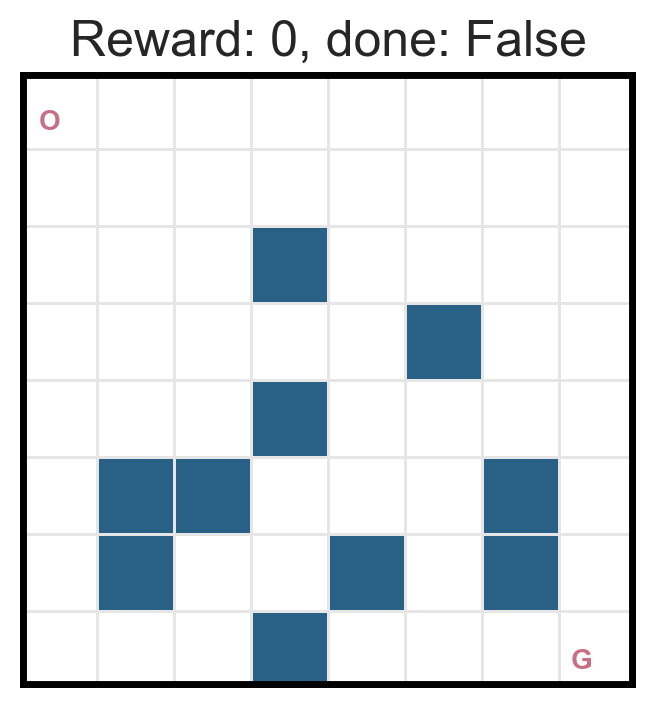

In [4]:
fig

# 介绍一下这个frozen_lake的游戏
* env.reset() 重置agent的位置到起始点
* env.step(a) a=[0, 1, 2, 3,] 代表上下左右
* env.p_s_next(s, a) 输入当前state s 和 action a, 输出转移到所有其他state的概率的向量
* env.r(s) 到达某个state时，返回(reward, bool done or not)
* env.s_termination 返回所有的终点的state, 包括窟窿和终点
* env.show_v(ax, V)  把所有状态的value画出来
* env.A, env.S 展示所有的action和state

In [ ]:
# [0,1,2,...,n_S]
env.S

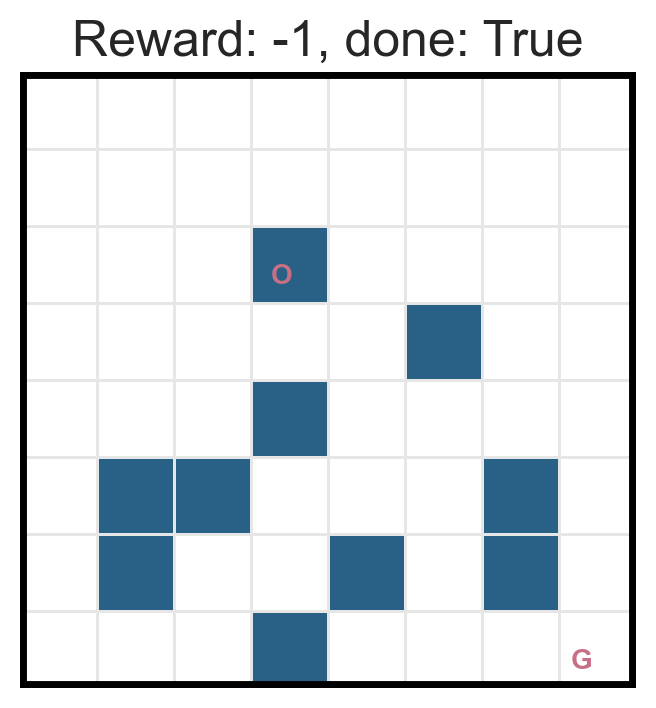

In [5]:
done = False
acts = [3, 3, 3, 1, 1, 1]
for a in acts:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    clear_output(True)
    env.render(ax)
    plt.show()
    if done: break
    _, _, done =env.step(a)
    time.sleep(.1)
    

## Have a look at the environment 

Actions: 

* 0: up
* 1: down
* 2: left
* 3: right

In [5]:
## check transition function
# check p_trans of a surface
env.p_s_next(s=1, a=2).round(2)

array([0.8 , 0.07, 0.07, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [6]:
# check p trans of a hole
env.p_s_next(s=19, a=2).round(2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
# check reward function of a surface, hole, and goal 
env.r(2), env.r(19), env.r(63), 

((0, False), (-1, True), (1, True))

## Policy evaluation 

In [10]:
# a random policy 
rng = np.random.RandomState(1234)
pi_rand = softmax(rng.rand(env.nS, env.nA)*5, axis=1)
pi_rand
# pi_rand是一个64 (state) x 4 (action)的矩阵，代表在某个state下执行四个action的概率

array([[0.0307586 , 0.26483744, 0.10534188, 0.59906209],
       [0.43947039, 0.0347665 , 0.03544608, 0.49031703],
       [0.5511548 , 0.36539615, 0.02739623, 0.05605283],
       [0.34377074, 0.39788796, 0.07180213, 0.18653917],
       [0.08613111, 0.00745807, 0.33181846, 0.57459236],
       [0.17378323, 0.60811237, 0.04086545, 0.17723895],
       [0.55593416, 0.13588923, 0.03812851, 0.2700481 ],
       [0.04514386, 0.15856537, 0.71430541, 0.08198537],
       [0.4416741 , 0.01642276, 0.27073458, 0.27116856],
       [0.01433183, 0.48924366, 0.04378215, 0.45264235],
       [0.03927629, 0.07318646, 0.03690516, 0.85063209],
       [0.37784904, 0.27808357, 0.0239985 , 0.32006889],
       [0.12952563, 0.30808345, 0.04359786, 0.51879306],
       [0.1249935 , 0.00763207, 0.1617007 , 0.70567373],
       [0.14151595, 0.38768729, 0.32825822, 0.14253854],
       [0.10281175, 0.56184634, 0.26964704, 0.06569487],
       [0.04412666, 0.00854072, 0.06240959, 0.88492302],
       [0.02965145, 0.02898278,

In [13]:
def policy_eval(pi, V, env, theta=1e-4, gamma=.99, show_value=False):

    # except v(terminal) = 0
    for s in env.s_termination:
        V[s] = 0

    # loop until convergence
    while True: 
        delta = 0
        for s in env.S:
            if s not in env.s_termination:
                v_old = V[s].copy()
                v_new = 0
                for a in env.A:
                    prob_next=env.p_s_next(s,a)
                    for s_next in env.S:
                        r, done = env.r(s_next)
                        # done的操作，结束了就是没有下一步了!
                        v_new+=pi[s,a]*prob_next[s_next]*(r+(1-done)*gamma*V[s_next])
                V[s] = v_new

                # get convergence
                delta_s=np.abs(v_new-v_old)
                delta   = np.max([delta, delta_s])

        # visualize your results
        if show_value:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
            clear_output(True)
            env.show_v(ax, V)
            time.sleep(1)
            plt.show()
        
        # check convergence
        if delta < theta: break 
    
    return V

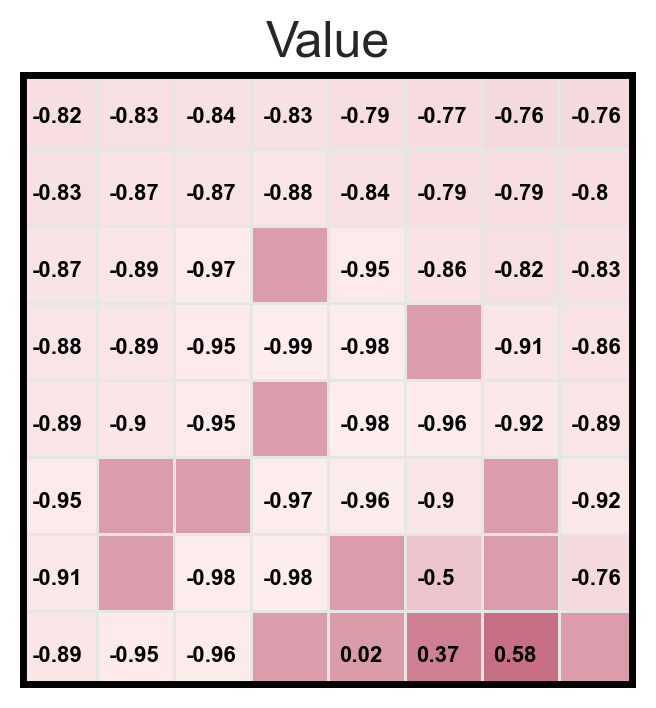

In [14]:
V = np.zeros([env.nS,])
V = policy_eval(pi_rand, V, env, show_value=True)